<a href="https://colab.research.google.com/github/dijkstra001/ia-bot-trader/blob/main/IA_bot_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IA Bot Trader**

Esse projeto tem como objetivo desenvolver uma IA para realizar recomendações de compra e venda de criptomoedas.

Os dados utilizados são da Exchange Bitmex e a API utilizada está disponível no link: https://www.bitmex.com/app/apiOverview

***Obs: Ao utilizar API para requisição dos dados, cuidado para não exceder o número de requisições.***

In [1]:
!pip install -q ccxt

In [2]:
!pip install -q bayesian-optimization==1.2

In [3]:
import csv
import ccxt
import time
import random
import types
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pprint import pprint
from bayes_opt import BayesianOptimization
from google.colab import drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def generate_csv(archive, data):
  with open(archive, mode = 'w') as archive_csv:
    archive_csv.write("Date,Open,High,Low,Close,Adj Close,Volume\n")

    csv_writer = csv.writer(archive_csv, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    csv_writer.writerows(data)

In [6]:
def exchange_connection(exchange, max_retries, symbol, timeframe, since, limit):
  num_retries = 0

  try:
    num_retries += 1
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
    return ohlcv

  except Exception:
      if num_retries > max_retries:
        raise

In [7]:
def extract_data(exchange, max_retries, symbol, timeframe, since, limit):
  earliest_timestamp = exchange.milliseconds()

  timeframe_duration_in_sec = exchange.parse_timeframe(timeframe)
  timeframe_duration_in_ms = timeframe_duration_in_sec * 1000
  timedelta = limit * timeframe_duration_in_ms

  all_ohlcv = []

  while True:
    fetch_since = earliest_timestamp - timedelta
    ohlcv = exchange_connection(exchange, max_retries, symbol, timeframe, fetch_since, limit)

    if ohlcv[0][0] >= earliest_timestamp:
      break
    earliest_timestamp = ohlcv[0][0]
    all_ohlcv = ohlcv + all_ohlcv
    print(f'{len(all_ohlcv)} registros extraídos de {exchange.iso8601(all_ohlcv[0][0])} a {exchange.iso8601(all_ohlcv[-1][0])}')

    if fetch_since < since:
      break
  
  return all_ohlcv

In [8]:
def extract_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True,})
    
    if isinstance(since, str):
        since = exchange.parse8601(since)
    exchange.load_markets()
    
    ohlcv = extract_data(exchange, max_retries, symbol, timeframe, since, limit)
    key = 0
    
    for item in ohlcv:
        epoch = int(item[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(item[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    ohlen = len(ohlcv)
    pprint("Número de Registros: " + str(ohlen))
    
    """if ohlen > 399:
        ohrem = ohlen - 399
        pprint("Removendo: " + str(ohrem))
        ohlcv = ohlcv[ohrem:]""" # Se não tiver recursos suficientes (ram e memória) descomente esse código
    
    generate_csv(filename, ohlcv)
    print('Salvos', len(ohlcv), 'registros no arquivo', filename)

In [9]:
# Exchange: https://www.bitmex.com/app/apiOverview
exchange = "bitmex"
symbol = "BTC/USD"
timeframe = "1d"
since = "2018-01-01T00:00:00Z"
max_retries = 3
outfile = "/content/drive/My Drive/ia-bot-trader/dataset.csv" # Aponte para o diretório onde você deseja salvar os dados

In [10]:
extract_to_csv(outfile, exchange, max_retries, symbol, timeframe, since, 100)

100 registros extraídos de 2021-02-08T00:00:00.000Z a 2021-05-18T00:00:00.000Z
200 registros extraídos de 2020-10-31T00:00:00.000Z a 2021-05-18T00:00:00.000Z
300 registros extraídos de 2020-07-23T00:00:00.000Z a 2021-05-18T00:00:00.000Z
400 registros extraídos de 2020-04-14T00:00:00.000Z a 2021-05-18T00:00:00.000Z
500 registros extraídos de 2020-01-05T00:00:00.000Z a 2021-05-18T00:00:00.000Z
600 registros extraídos de 2019-09-27T00:00:00.000Z a 2021-05-18T00:00:00.000Z
700 registros extraídos de 2019-06-19T00:00:00.000Z a 2021-05-18T00:00:00.000Z
800 registros extraídos de 2019-03-11T00:00:00.000Z a 2021-05-18T00:00:00.000Z
900 registros extraídos de 2018-12-01T00:00:00.000Z a 2021-05-18T00:00:00.000Z
1000 registros extraídos de 2018-08-23T00:00:00.000Z a 2021-05-18T00:00:00.000Z
1100 registros extraídos de 2018-05-15T00:00:00.000Z a 2021-05-18T00:00:00.000Z
1200 registros extraídos de 2018-02-04T00:00:00.000Z a 2021-05-18T00:00:00.000Z
1300 registros extraídos de 2017-10-27T00:00:00.0

# **Análise Exploratória:**

In [11]:
dataset = pd.read_csv(outfile)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-27,5888.4,6013.0,5678.0,5769.3,5769.3,632848491
1,2017-10-28,5769.3,5878.0,5652.7,5727.1,5727.1,444659626
2,2017-10-29,5727.1,6366.0,5687.5,6159.3,6159.3,756109936
3,2017-10-30,6159.3,6221.8,6010.8,6134.9,6134.9,579186740
4,2017-10-31,6134.9,6489.0,6088.4,6440.1,6440.1,757390412


In [12]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1.300000e+03
mean,13033.138000,13453.447692,12567.486769,13063.581538,13063.581538,2.321310e+09
std,13193.496998,13641.716347,12671.109624,13222.626731,13222.626731,1.421137e+09
min,3183.000000,3226.000000,3121.000000,3183.000000,3183.000000,3.202566e+08
25%,6702.625000,6870.250000,6515.750000,6705.625000,6705.625000,1.325508e+09
50%,8827.250000,9064.500000,8574.750000,8833.750000,8833.750000,2.073151e+09
75%,11246.000000,11556.250000,10865.000000,11259.000000,11259.000000,2.928324e+09
max,63674.000000,65000.000000,62131.000000,63674.000000,63674.000000,1.362211e+10


In [13]:
# Dados de fechamento:
close = dataset.Close.values.tolist()

# Parâmetros para versão base do modelo:
window_size = 30
skip = 5
l = len(close) - 1

## **Estratégia de Treinamento: Deep Evolution Strategy (OpenIA):**

In [14]:
class PoliticsTrader:
  inputs = None

  def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

  def get_weights_population(self, weights, population):
    
        weights_population = []
        
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        
        return weights_population

  def get_weights(self):
        return self.weights

  def train(self, epoch = 100, print_every = 1):
        
        lasttime = time.time()
        
        for i in range(epoch):
            
            population = []
            rewards = np.zeros(self.population_size)

            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            
            for k in range(self.population_size):
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            if (i + 1) % print_every == 0:
                print('Iteração %d. Recompensa: %f' % (i + 1, self.reward_function(self.weights)))
        
        print('Tempo Total de Treinamento:', time.time() - lasttime, 'segundos')


## **Arquitetura do Modelo de Rede Neural:**

In [15]:
class Model:
    
    def __init__(self, input_size, layer_size, output_size):
        
        self.weights = [np.random.randn(input_size, layer_size),
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size),]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

## **Configuração do BOT:**

In [16]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    states = []
    for i in range(n - 1):
        states.append(block[i + 1] - block[i])
    return np.array([states])

In [17]:
class Trader:

    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size,):
        
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticsTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE,)

    def execute(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        
        initial_money = self.initial_money
        starting_money = initial_money
        
        self.model.weights = weights

        state = get_state(close, 0, self.window_size + 1)

        inventory = []
        quantity = 0
        
        for t in range(0, l, self.skip):
            
            action, buy = self.execute(state)
            
            next_state = get_state(close, t + 1, self.window_size + 1)
          
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                    
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def make_investiment(self):
        
        initial_money = self.initial_money
        starting_money = initial_money
        
        state = get_state(close, 0, self.window_size + 1)
              
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        
        for t in range(0, l, self.skip):
            
            action, buy = self.execute(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                
                print('Dia %d: comprar %d unidades ao preço de %f, saldo total %f' % (t, buy_units, total_buy, initial_money))
            
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                
                print('Dia %d, vender %d unidades ao preço de %f, investimento %f %%, saldo total %f,' % (t, sell_units, total_sell, invest, initial_money))
            
            # Próximo estado
            state = next_state

        # Investimento
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        print('\nGanho Total %f, Valor Total Investido %f' % (initial_money - starting_money, invest))
        
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'Valor Real de Fechamento', c = 'g')
        plt.plot(close, 'X', label = 'Previsão de Compra', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'Previsão de Venda', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

## **Encontrando o melhor Trader:**

In [18]:
def best_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    model = Model(window_size, size_network, 3)
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 5, 5, skip, window_size,)
    
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [19]:
def find_best_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    global accbest
    
    param = {'window_size': int(np.around(window_size)),
             'skip': int(np.around(skip)),
             'population_size': int(np.around(population_size)),
             'sigma': max(min(sigma, 1), 0.0001),
             'learning_rate': max(min(learning_rate, 0.5), 0.000001),
             'size_network': int(np.around(size_network)),}
    
    print('\nBuscando Parâmetros %s' % (param))
    
    investment = best_trader(**param)
    print('Após 100 iterações o investimento foi de %f' % (investment))
    return investment

## **Otimização Bayesiana Para os Hiperparâmetros do Modelo:**

In [20]:
bayesianOpt = BayesianOptimization(find_best_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.49),
                                                                  'size_network': (10, 1000),},)

In [21]:
%%time
bayesianOpt.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 30, 'skip': 8, 'population_size': 28, 'sigma': 0.3340527819601831, 'learning_rate': 0.22172934296001587, 'size_network': 482}
Tempo Total de Treinamento: 20.362088680267334 segundos
Após 100 iterações o investimento foi de 16808.885000
|  1        |  1.681e+0 |  0.2217   |  27.63    |  0.3341   |  482.5    |  8.055    |  30.44    |

Buscando Parâmetros {'window_size': 14, 'skip': 13, 'population_size': 31, 'sigma': 0.518651035606628, 'learning_rate': 0.31526740545397747, 'size_network': 824}
Tempo Total de Treinamento: 13.427136421203613 segundos
Após 100 iterações o investimento foi de 13826.600000
|  2        |  1.383e+0 |  0.3153   |  30.98    |  0.5187   |  824.1    |  12.92    |  13.9     |

Buscando Parâmetros {'window_size': 38, 'skip': 9, 'populatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  14       |  0.0      |  0.3698   |  27.84    |  0.03807  |  643.9    |  13.96    |  44.73    |

Buscando Parâmetros {'window_size': 22, 'skip': 14, 'population_size': 17, 'sigma': 0.3198742283858919, 'learning_rate': 0.05184682738417897, 'size_network': 138}
Tempo Total de Treinamento: 3.791943311691284 segundos
Após 100 iterações o investimento foi de 4250.360000
|  15       |  4.25e+03 |  0.05185  |  17.35    |  0.3199   |  137.9    |  13.75    |  21.63    |

Buscando Parâmetros {'window_size': 16, 'skip': 8, 'population_size': 22, 'sigma': 0.174378711619371, 'learning_rate': 0.2421280118035837, 'size_network': 250}
Tempo Total de Treinamento: 8.214690685272217 segundos
Após 100 iterações o investimento foi de 8812.576000
|  16       |  8.813e+0 |  0.2421   |  22.11    |  0.1744   |  250.0    |  8.204    |  15.79    |

Buscando Parâmetros {'window_size': 35, 'skip': 15, 'population_size': 36, 'sigma': 0.9075370856071657, 'learning_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  32       |  0.0      |  0.264    |  39.96    |  0.03682  |  450.6    |  3.227    |  6.738    |

Buscando Parâmetros {'window_size': 44, 'skip': 4, 'population_size': 17, 'sigma': 0.5209367900091589, 'learning_rate': 0.18967540060434543, 'size_network': 723}
Tempo Total de Treinamento: 29.53978991508484 segundos
Após 100 iterações o investimento foi de 22502.965000
|  33       |  2.25e+04 |  0.1897   |  16.71    |  0.5209   |  723.3    |  3.538    |  44.25    |

Buscando Parâmetros {'window_size': 15, 'skip': 14, 'population_size': 9, 'sigma': 0.5062788116208907, 'learning_rate': 0.2608554084921492, 'size_network': 713}
Tempo Total de Treinamento: 3.7535576820373535 segundos
Após 100 iterações o investimento foi de 9504.800000
|  34       |  9.505e+0 |  0.2609   |  8.671    |  0.5063   |  713.0    |  14.06    |  15.2     |

Buscando Parâmetros {'window_size': 27, 'skip': 10, 'population_size': 7, 'sigma': 0.16054201523612127, 'learnin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  48       |  0.0      |  0.02955  |  6.899    |  0.02921  |  539.0    |  14.68    |  18.8     |

Buscando Parâmetros {'window_size': 17, 'skip': 3, 'population_size': 13, 'sigma': 0.1414043439441543, 'learning_rate': 0.11745213569276174, 'size_network': 957}
Tempo Total de Treinamento: 21.911470890045166 segundos
Após 100 iterações o investimento foi de 9422.055000
|  49       |  9.422e+0 |  0.1175   |  13.03    |  0.1414   |  956.7    |  2.656    |  16.72    |

Buscando Parâmetros {'window_size': 9, 'skip': 2, 'population_size': 19, 'sigma': 0.27832108181703796, 'learning_rate': 0.006273308551171384, 'size_network': 39}
Tempo Total de Treinamento: 21.280402660369873 segundos
Após 100 iterações o investimento foi de 2150.236000
|  50       |  2.15e+03 |  0.006273 |  18.68    |  0.2783   |  38.62    |  2.12     |  8.808    |

Buscando Parâmetros {'window_size': 14, 'skip': 5, 'population_size': 25, 'sigma': 0.333558244304471, 'learning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide



Buscando Parâmetros {'window_size': 22, 'skip': 8, 'population_size': 9, 'sigma': 0.5383925244785479, 'learning_rate': 0.10064418365296245, 'size_network': 820}
Tempo Total de Treinamento: 6.837114095687866 segundos
Após 100 iterações o investimento foi de 9284.900000
|  75       |  9.285e+0 |  0.1006   |  9.056    |  0.5384   |  820.2    |  7.537    |  21.84    |

Buscando Parâmetros {'window_size': 26, 'skip': 3, 'population_size': 19, 'sigma': 0.5210710484537566, 'learning_rate': 0.4899639214764199, 'size_network': 627}
Tempo Total de Treinamento: 33.325393199920654 segundos
Após 100 iterações o investimento foi de 20927.235000
|  76       |  2.093e+0 |  0.49     |  19.32    |  0.5211   |  627.2    |  2.985    |  26.41    |

Buscando Parâmetros {'window_size': 27, 'skip': 8, 'population_size': 11, 'sigma': 0.09183189752265425, 'learning_rate': 0.012711954093966233, 'size_network': 220}
Tempo Total de Treinamento: 4.5742433071136475 segundos
Após 100 iterações o investimento foi de 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


**Resultado do modelo:**

In [22]:
bayesianOpt.res

[{'params': {'learning_rate': 0.22172934296001587,
   'population_size': 27.63053502953973,
   'sigma': 0.3340527819601831,
   'size_network': 482.47876600577354,
   'skip': 8.055428054884167,
   'window_size': 30.444155581687866},
  'target': 16808.885000000002},
 {'params': {'learning_rate': 0.31526740545397747,
   'population_size': 30.975249508914807,
   'sigma': 0.518651035606628,
   'size_network': 824.07271418154,
   'skip': 12.918373074377334,
   'window_size': 13.901398579893614},
  'target': 13826.599999999999},
 {'params': {'learning_rate': 0.019824291474773978,
   'population_size': 29.43748310837673,
   'sigma': 0.23448088751673557,
   'size_network': 86.6988852582371,
   'skip': 9.149526801519873,
   'window_size': 37.8754526994477},
  'target': 6214.96},
 {'params': {'learning_rate': 0.15511418317126907,
   'population_size': 41.64518440153391,
   'sigma': 0.9118304069324653,
   'size_network': 950.6415213447445,
   'skip': 11.85000954191041,
   'window_size': 42.1313740

In [23]:
max([dic['target'] for dic in bayesianOpt.res])

23317.82

In [24]:
[dic['params'] for dic in bayesianOpt.res]

[{'learning_rate': 0.22172934296001587,
  'population_size': 27.63053502953973,
  'sigma': 0.3340527819601831,
  'size_network': 482.47876600577354,
  'skip': 8.055428054884167,
  'window_size': 30.444155581687866},
 {'learning_rate': 0.31526740545397747,
  'population_size': 30.975249508914807,
  'sigma': 0.518651035606628,
  'size_network': 824.07271418154,
  'skip': 12.918373074377334,
  'window_size': 13.901398579893614},
 {'learning_rate': 0.019824291474773978,
  'population_size': 29.43748310837673,
  'sigma': 0.23448088751673557,
  'size_network': 86.6988852582371,
  'skip': 9.149526801519873,
  'window_size': 37.8754526994477},
 {'learning_rate': 0.15511418317126907,
  'population_size': 41.64518440153391,
  'sigma': 0.9118304069324653,
  'size_network': 950.6415213447445,
  'skip': 11.85000954191041,
  'window_size': 42.13137407782133},
 {'learning_rate': 0.04082239236168592,
  'population_size': 14.702334317223327,
  'sigma': 0.5753457855520072,
  'size_network': 104.64620847

In [25]:
max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]])

0.4899639214764199

In [26]:
max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]])

0.9833752002579884

In [27]:
max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]])

989.4270907402063

## **Execução da IA:**

In [28]:
%%time
best_trader(window_size = 30, 
              skip = 1, 
              population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              size_network = 500)

Tempo Total de Treinamento: 71.55461525917053 segundos
CPU times: user 1min 19s, sys: 1min, total: 2min 20s
Wall time: 1min 11s


7986.47

## **Execução do modelo base:**

In [31]:
base_model = Model(input_size = 30, layer_size = 500, output_size = 3)

trader_base = Trader(population_size = 15, 
                     sigma = 0.1, 
                     learning_rate = 0.03, 
                     model = base_model, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = 1, 
                     window_size = 30)

In [32]:
%%time
trader_base.fit(500, 100)

Iteração 100. Recompensa: 10099.600000
Iteração 200. Recompensa: 18919.887000
Iteração 300. Recompensa: 21964.470000
Iteração 400. Recompensa: 24825.915000
Iteração 500. Recompensa: 27382.455000
Tempo Total de Treinamento: 360.31381392478943 segundos
CPU times: user 6min 40s, sys: 5min 7s, total: 11min 48s
Wall time: 6min


## **Gerando as recomentações, com base no modelo-base:**

Dia 2: comprar 5 unidades ao preço de 30796.500000, saldo total -20796.500000
Dia 3, vender 5 unidades ao preço de 30674.500000, investimento -0.396149 %, saldo total 9878.000000,
Dia 5: comprar 5 unidades ao preço de 33747.500000, saldo total -23869.500000
Dia 12, vender 5 unidades ao preço de 37325.000000, investimento 10.600785 %, saldo total 13455.500000,
Dia 15: comprar 5 unidades ao preço de 31727.500000, saldo total -18272.000000
Dia 17, vender 5 unidades ao preço de 32790.000000, investimento 3.348830 %, saldo total 14518.000000,
Dia 20: comprar 5 unidades ao preço de 39335.000000, saldo total -24817.000000
Dia 24, vender 5 unidades ao preço de 41215.000000, investimento 4.779458 %, saldo total 16398.000000,
Dia 26: comprar 5 unidades ao preço de 41095.000000, saldo total -24697.000000
Dia 30, vender 5 unidades ao preço de 46695.000000, investimento 13.626962 %, saldo total 21998.000000,
Dia 32: comprar 5 unidades ao preço de 49690.000000, saldo total -27692.000000
Dia 35, vend

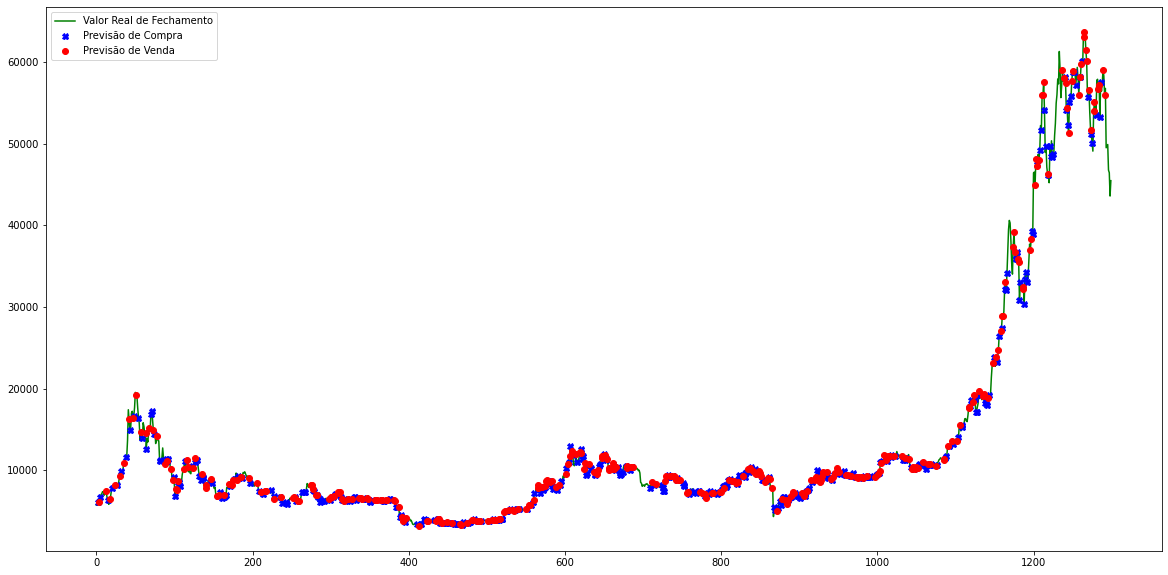

In [33]:
trader_base.make_investiment()

## **Execução da IA com modelo otimizado:**

In [34]:
%%time
best_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in bayesianOpt.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]]))))

Tempo Total de Treinamento: 37.83869647979736 segundos
CPU times: user 42.2 s, sys: 29.9 s, total: 1min 12s
Wall time: 37.9 s


13118.265

In [35]:
%%time
opt_model = Model(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     output_size = 3)

CPU times: user 3.33 ms, sys: 1.12 ms, total: 4.45 ms
Wall time: 4.57 ms


## **Criação do modelo otimizado:**

In [36]:
trader_opt = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
                     model = opt_model, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))))

## **Treinamento do modelo otimizado:**



In [38]:
%%time
trader_opt.fit(500, 100)

Iteração 100. Recompensa: 11079.775000
Iteração 200. Recompensa: 13578.245000
Iteração 300. Recompensa: 13641.820000
Iteração 400. Recompensa: 14998.340000
Iteração 500. Recompensa: 14977.815000
Tempo Total de Treinamento: 195.30599069595337 segundos
CPU times: user 3min 39s, sys: 2min 31s, total: 6min 10s
Wall time: 3min 15s


## **Realizando as recomendações, com base no modelo otimizado:**

Dia 0: comprar 5 unidades ao preço de 28846.500000, saldo total -18846.500000
Dia 45, vender 5 unidades ao preço de 85045.000000, investimento 194.819129 %, saldo total 66198.500000,
Dia 105: comprar 5 unidades ao preço de 43377.500000, saldo total 22821.000000
Dia 120: comprar 1 unidades ao preço de 9689.000000, saldo total 13132.000000
Dia 135, vender 5 unidades ao preço de 47715.000000, investimento 9.999424 %, saldo total 60847.000000,
Dia 165: comprar 5 unidades ao preço de 34120.000000, saldo total 26727.000000
Dia 180, vender 5 unidades ao preço de 44232.500000, investimento 356.522861 %, saldo total 70959.500000,
Dia 195, vender 1 unidades ao preço de 9027.500000, investimento -73.541911 %, saldo total 79987.000000,
Dia 225: comprar 5 unidades ao preço de 37460.000000, saldo total 42527.000000
Dia 240: comprar 5 unidades ao preço de 30750.000000, saldo total 11777.000000
Dia 255, vender 5 unidades ao preço de 33340.000000, investimento -10.998398 %, saldo total 45117.000000,
Di

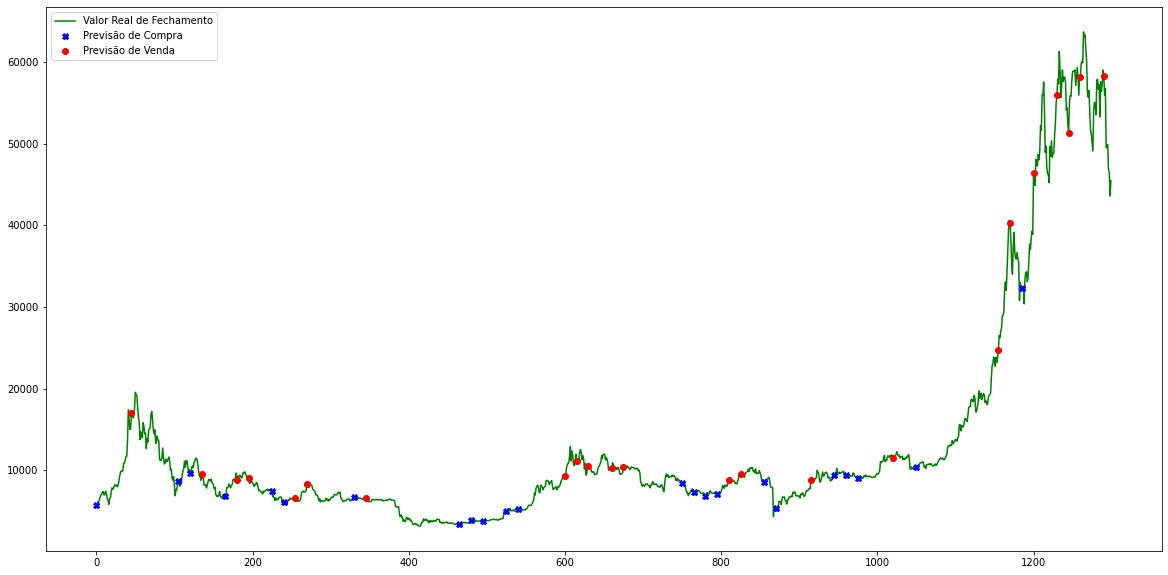

CPU times: user 295 ms, sys: 138 ms, total: 433 ms
Wall time: 299 ms


In [39]:
%%time
trader_opt.make_investiment()